<a href="https://colab.research.google.com/github/ericyoc/hnn_attack_three_diff_defense_choices_poc/blob/main/hnn_attack_three_diff_defense_choices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classical-Quantum or Hybrid Nerual Network that combines Quantum Neural Network (QNN) and Convolutional Neural Network (CNN) Model Using either MNIST or EMNIST Datasets with Protection Using Adverarial Training Against Compounded Attacks

Make sure to set runtime to GPU (e.g., Google Colab T4 GPU) instead of CPU

Assumes that datasets are on Google Drive and that Google Drive will be mounted with default directory structure

ATTENTION: MUST INSTALL THE MINIMUM PYTHON MODULE VERSIONS FOR PYTHON CODE TO WORK CORRECTLY

Python version: 3.8.18
torch: 2.2.1
torchvision: 0.17.1
torchattacks: 3.5.1
numpy: 1.23.5
tabulate: 0.9.0

In [1]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install torchattacks
import torchattacks

In [3]:
global defense_type
defense_type = "input_transformation"  # Options: "adversarial_training", "randomization", "input_transformation"

global randomization_defense
randomization_defense = "combined_randomization"  # Options: "random_resizing", "random_cropping", "random_rotation", "combined_randomization"

global input_transformation
input_transformation = "combined_input_transformation"  # Options: "image_quilting", "adversarial_logit_pairing", "differential_privacy", "combined_input_transformation"

In [4]:
#Pick a compounded adversarial attack from the following: fgsm_cw_attack, fgsm_pgd_attack, cw_pgd_attack, pgd_bim_attack, fgsm_bim_attack, cw_bim_attack
# fgsm_deepfool_attack, pgd_deepfool_attack, cw_deepfool_attack, bim_deepfool_attack
global compounded_attack_name

compounded_attack_name = "fgsm_cw_attack"

In [5]:
# Set the dataset_name
global dataset_name
dataset_name = 'MNIST'  # 'MNIST' or 'EMNIST' or 'SVHN' or 'USPS' or 'Semeion'

In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access the mounted drive
drive_path = '/content/drive/My Drive/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch
global device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
global num_epochs
num_epochs = 10

In [9]:
#!pip install cirq
import cirq
#!pip install cirq-google
#import cirq_google

In [10]:
import sys
import pkg_resources
import importlib

def get_package_versions(packages):
    versions = {}
    for package in packages:
        try:
            module = importlib.import_module(package)
            if hasattr(module, '__version__'):
                versions[package] = module.__version__
            elif package == 'cirq':
                versions[package] = cirq.__version__
            else:
                versions[package] = 'Not Found'
        except ImportError:
            versions[package] = 'Not Installed'
    return versions

# Specify the list of packages you want to check
packages_to_check = ["torch", "torchvision", "torchattacks", "torchvision", "numpy", "tabulate", "cirq","cirq_google"]

# Call the function to get package versions
versions = get_package_versions(packages_to_check)

In [11]:
# Get the Python version
python_version = sys.version.split()[0]

# Call the function to get package versions
versions = get_package_versions(packages_to_check)

# Print the Python version
print(f"Python version: {python_version}")

# Print the package versions
for package_name, version in versions.items():
    print(f"{package_name}: {version}")

Python version: 3.10.12
torch: 2.3.0+cu121
torchvision: 0.18.0+cu121
torchattacks: 3.5.1
numpy: 1.25.2
tabulate: 0.9.0
cirq: 1.3.0
cirq_google: 1.3.0


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

theta is the rotation angle applied to even-indexed qubits (0, 2, 4, ...) using the cirq.ry(theta) gate.

phi is the rotation angle applied to odd-indexed qubits (1, 3, 5, ...) using the cirq.ry(phi) gate.

These rotation gates introduce controlled dynamics into the quantum circuit, and by varying the values of theta and phi, we can modify the evolution of the quantum state and potentially increase the expressive power of the circuit.

During training, theta and phi are initialized as PyTorch tensors with requires_grad=True, allowing their values to be optimized via backpropagation

In [13]:
 # Initialize trainable parameters for the quantum circuit
global theta
global phi
theta = torch.randn(1, requires_grad=True, device=device)
phi = torch.randn(1, requires_grad=True, device=device)

The create_quantum_circuit function has two types of quantum gates being used: rotation gates and entangling gates.

Rotation Gates:
The code uses the cirq.ry gate, which represents a rotation around the Y-axis of the Bloch sphere.
The cirq.ry(theta)(qubit) applies a rotation by an angle theta around the Y-axis to the specified qubit.
In the code, there are two fixed rotation angles used: theta and phi.
The rotation gates are applied to each qubit in an alternating manner based on the qubit index.
If the qubit index is even (i % 2 == 0), a rotation by angle theta is applied using cirq.ry(theta)(qubit).
If the qubit index is odd (i % 2 != 0), a rotation by angle phi is applied using cirq.ry(phi)(qubit).
Rotation gates introduce single-qubit operations that can manipulate the state of individual qubits.

Entangling Gates:
The code uses the cirq.CNOT gate, which represents the controlled-NOT operation.
The cirq.CNOT(control_qubit, target_qubit) applies a CNOT gate with control_qubit as the control and target_qubit as the target.
In the code, CNOT gates are applied between pairs of adjacent qubits.
The loop for i in range(num_qubits - 1) iterates over the qubits, skipping the last one.

For each pair of adjacent qubits qubits[i] and qubits[i+1], a CNOT gate is appended to the circuit using circuit.append(cirq.CNOT(qubits[i], qubits[i+1])).
CNOT gates create entanglement between qubits, allowing for multi-qubit operations and introducing correlations between the states of different qubits.
The purpose of using these quantum gates in the circuit is to introduce quantum operations that can manipulate the state of the qubits. The rotation gates (cirq.ry) allow for single-qubit transformations, while the entangling gates (cirq.CNOT) create entanglement and enable multi-qubit operations.

By applying a combination of rotation gates and entangling gates, the quantum circuit can perform quantum computations and potentially capture complex patterns and correlations in the data. The specific choice of gates and their arrangement depends on the desired quantum algorithm and the problem being solved.

Note: The code uses fixed rotation angles (theta and phi) for simplicity, but in practice, these angles can be parameterized and learnable during the training process of the hybrid model.

In [14]:
import math

def create_quantum_circuit(theta, phi, output_dim):

    # Check if output_dim is valid
    if output_dim <= 0:
        print(f"Output dimension {output_dim} is invalid. Returning an empty circuit.")
        return cirq.Circuit()

    # Number of qubits required for output_dim classes
    num_qubits = int(math.ceil(math.log2(output_dim)))

    # Create qubits
    qubits = cirq.LineQubit.range(num_qubits)

    # Initialize quantum circuit
    circuit = cirq.Circuit()

    # Apply fixed rotations to each qubit
    theta = 0.5
    phi = 0.3
    for i, qubit in enumerate(qubits):
        if i % 2 == 0:
            circuit.append(cirq.ry(theta)(qubit))
        else:
            circuit.append(cirq.ry(phi)(qubit))

    # Apply entangling gates (e.g., CNOT gates)
    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))

    return circuit

In [15]:
def simulate_circuit(circuit, device):

    if device == "gpu":
        # Create a GPU-accelerated simulator
        simulator = cirq.TensorflowSimulator(tensor_env=tf.distribute.cluster_resolver.TPUClusterResolver())
    else:
        # Create a CPU simulator
        simulator = cirq.Simulator()

    result = simulator.simulate(circuit)
    final_state_vector = result.final_state_vector

    return final_state_vector


In [16]:
# Create the quantum circuit
quantum_circuit = create_quantum_circuit(theta, phi, 10)

# Print the circuit
print(quantum_circuit)

0: ───Ry(0.159π)───@───────────
                   │
1: ───Ry(0.095π)───X───@───────
                       │
2: ───Ry(0.159π)───────X───@───
                           │
3: ───Ry(0.095π)───────────X───


In [17]:
# Simulate the circuit on CPU
cpu_state_vector = simulate_circuit(quantum_circuit, device="cpu")
print("CPU state vector:", cpu_state_vector)

CPU state vector: [0.9178265 +0.j 0.1387159 +0.j 0.03541998+0.j 0.23435956+0.j
 0.03541998+0.j 0.00535321+0.j 0.02096485+0.j 0.13871588+0.j
 0.03541998+0.j 0.00535321+0.j 0.0013669 +0.j 0.00904421+0.j
 0.05984182+0.j 0.00904421+0.j 0.03541998+0.j 0.23435956+0.j]


In [18]:
# Simulate the circuit on GPU (if available)
try:
    gpu_state_vector = simulate_circuit(quantum_circuit, device="gpu")
    print("GPU state vector:", gpu_state_vector)
except Exception as e:
    print("GPU acceleration is not available on this system.")
    print(e)

GPU acceleration is not available on this system.
module 'cirq' has no attribute 'TensorflowSimulator'


In [19]:
def hybrid_forward(input_data, classical_model, theta, phi, device, output_dim=10):
    # Move input data to the specified device
    input_data = input_data.to(device)

    # Pass input through classical model
    classical_output = classical_model(input_data)

    # Construct quantum circuit based on classical output
    quantum_circuit = create_quantum_circuit(theta, phi, output_dim)

    # Simulate quantum circuit and extract results
    simulator = cirq.Simulator()
    result = simulator.simulate(quantum_circuit)
    quantum_output_amplitudes = result.final_state_vector

    # Get the batch size from the classical output
    batch_size = classical_output.size(0)

    # Reshape classical output to match quantum output dimensions
    classical_output = classical_output.view(batch_size, -1)

    # Compute the squared amplitudes (probabilities) of the quantum output
    num_qubits = int(math.ceil(math.log2(output_dim)))
    expected_quantum_output_size = 2 ** num_qubits
    quantum_output_probabilities = np.square(np.abs(quantum_output_amplitudes))
    quantum_output_probabilities = quantum_output_probabilities.reshape(expected_quantum_output_size)[:output_dim]

    # Repeat the quantum output probabilities for each batch element
    quantum_output_probabilities = np.tile(quantum_output_probabilities, (batch_size, 1))

    # Convert quantum output probabilities to PyTorch tensor
    quantum_output_probabilities = torch.from_numpy(quantum_output_probabilities).to(device)

    # Combine classical and quantum outputs using a linear combination
    alpha = 0.5  # Weight for the classical output
    beta = 0.5  # Weight for the quantum output
    hybrid_output = alpha * classical_output + beta * quantum_output_probabilities

    # Apply log_softmax to the hybrid output
    hybrid_output = F.log_softmax(hybrid_output, dim=1)

    return hybrid_output

CNN architecture is designed to recognize digits 0 to 9 in the MNIST type dataset.

Input:
The MNIST dataset consists of grayscale images of handwritten digits.
Each image has a size of 28x28 pixels.
The input to the CNN is expected to be a tensor of shape (batch_size, 1, 28, 28), where 1 represents the single color channel (grayscale).

Convolutional Layers:
The first convolutional layer (self.conv1) has 1 input channel (grayscale) and 4 output feature maps. It uses a kernel size of 5x5 to learn local patterns in the input image.

The second convolutional layer (self.conv2) has 4 input feature maps (output from conv1) and 10 output feature maps. It also uses a kernel size of 5x5 to learn higher-level features.

Max pooling is applied after each convolutional layer to downsample the feature maps and reduce spatial dimensions.

Fully Connected Layers:
After the convolutional layers, the feature maps are flattened into a 1D vector.
The flattened vector is passed through two fully connected layers (self.fc1 and self.fc2) to learn non-linear combinations of the extracted features.
The output of the last fully connected layer (self.fc2) has 10 units, corresponding to the 10 digit classes (0 to 9).

Output:
The output of the CNN is a tensor of shape (batch_size, 10), representing the predicted probabilities for each digit class.
The log_softmax activation function is applied to the output to obtain normalized log probabilities.

During training, the CNN learns to map the input images to their corresponding digit labels by adjusting the weights of the convolutional and fully connected layers. The network learns to extract relevant features and patterns from the images that are discriminative for digit recognition.

At inference time, given an input image of a handwritten digit, the trained CNN will predict the probability distribution over the 10 digit classes. The class with the highest probability is typically considered as the predicted digit.

In [20]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer
        # Input: 1 channel (grayscale image)
        # Output: 4 feature maps
        # Kernel size: 5x5
        self.conv1 = nn.Conv2d(1, 4, 5)

        # Second convolutional layer
        # Input: 4 feature maps
        # Output: 10 feature maps
        # Kernel size: 5x5
        self.conv2 = nn.Conv2d(4, 10, 5)

        # First fully connected layer
        # Input: 160 features (flattened output from conv2)
        # Output: 80 features
        self.fc1 = nn.Linear(160, 80)

        # Second fully connected layer
        # Input: 80 features
        # Output: 10 features (corresponding to 10 classes)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        # Apply first convolutional layer and ReLU activation
        x = F.relu(self.conv1(x))

        # Apply max pooling with kernel size 2x2
        x = F.max_pool2d(x, 2)

        # Apply second convolutional layer and ReLU activation
        x = F.relu(self.conv2(x))

        # Apply max pooling with kernel size 2x2
        x = F.max_pool2d(x, 2)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 160)

        # Apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer
        x = self.fc2(x)

        # Apply log softmax activation to get class probabilities
        return F.log_softmax(x, dim=1)

In [21]:
classical_model = CNN().to(device)

print("Model Architecture:")
print(classical_model)

Model Architecture:
CNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=160, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


The Hybrid Neural Network (HNN) combines a classical model (e.g., CNN) with a quantum circuit. The purpose of the HNN is to enhance the performance of the classical model by leveraging the capabilities of quantum computing.

The HNN supports the CNN in recognizing MNIST digits 0-9 as explained below:

Integration with the Classical Model:
The HNN takes the classical model (CNN) as an input parameter (classical_model) during initialization.
The classical model is stored as an attribute of the HNN using self.classical_model = classical_model.
This allows the HNN to access and utilize the features and predictions of the CNN.

Quantum Circuit Parameters:
The HNN initializes trainable parameters (self.theta and self.phi) for the quantum circuit.
These parameters represent the angles of rotation gates in the quantum circuit and are learned during the training process.
The quantum circuit introduces additional non-linearity and expressiveness to the model, potentially enhancing its ability to capture complex patterns in the data.

Forward Pass:
In the forward method of the HNN, the input data (input_data) is passed to the hybrid_forward function along with the classical model, quantum circuit parameters, device, and output dimension.
The hybrid_forward function is responsible for integrating the classical model with the quantum circuit.
It takes the features extracted by the CNN and uses them as input to the quantum circuit.
The quantum circuit applies quantum operations based on the learned parameters (self.theta and self.phi) to transform the input features.
The output of the quantum circuit is then processed and combined with the classical model's predictions to produce the final output.

Hybrid Learning:
During the training process, both the classical model (CNN) and the quantum circuit parameters (self.theta and self.phi) are optimized jointly.
The gradients are propagated through the hybrid model, allowing the CNN and the quantum circuit to learn and adapt together.
The quantum circuit can potentially learn to extract additional features or patterns that complement the CNN's capabilities.

Output Dimension:
The HNN's output dimension (output_dim) is set to 10, corresponding to the 10 digit classes (0 to 9) in the MNIST dataset.
The hybrid model's final output represents the predicted probabilities for each digit class.

By combining the CNN with a quantum circuit, the HNN aims to leverage the strengths of both classical and quantum computing. The quantum circuit can potentially capture additional patterns and correlations in the data that the CNN alone might miss. The hybrid approach allows for the exploration of quantum-enhanced feature extraction and classification.

In [22]:
class HNN(nn.Module):
    def __init__(self, classical_model, device, output_dim=10):
        super(HNN, self).__init__()

        # Store the classical model as an attribute
        self.classical_model = classical_model

        # Store the output dimension as an attribute
        self.output_dim = output_dim

        # Initialize trainable parameters for the quantum circuit
        self.theta = nn.Parameter(torch.randn(1))
        self.phi = nn.Parameter(torch.randn(1))

        # Store the device as an attribute
        self.device = device

        # Move the model to the specified device if it's not None
        if device is not None:
            self.to(device)

    def forward(self, input_data):
        # Call the hybrid_forward function with the input data, classical model,
        # quantum circuit parameters (theta and phi), device, and output dimension
        return hybrid_forward(input_data, self.classical_model, self.theta, self.phi, self.device, self.output_dim)

In [23]:
# Create an instance of the hybrid model
hybrid_model = HNN(classical_model, device=device, output_dim=10).to(device)

In [24]:
# Print the hybrid model architecture
print("Hybrid Model Architecture:")
print(hybrid_model)

Hybrid Model Architecture:
HNN(
  (classical_model): CNN(
    (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=160, out_features=80, bias=True)
    (fc2): Linear(in_features=80, out_features=10, bias=True)
  )
)


In [25]:
optimizer = optim.Adam(classical_model.parameters())

In [26]:
loss_fn = nn.NLLLoss()

In [27]:
import gzip
import numpy as np
from torchvision import transforms

def load_emnist_digits(data_dir, train=True, transform=None, filtered=range(10)):
    if train:
        image_file = 'emnist-digits-train-images-idx3-ubyte.gz'
        label_file = 'emnist-digits-train-labels-idx1-ubyte.gz'
    else:
        image_file = 'emnist-digits-test-images-idx3-ubyte.gz'
        label_file = 'emnist-digits-test-labels-idx1-ubyte.gz'

    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(data_dir, label_file)

    with gzip.open(image_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    with gzip.open(label_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    dataset = EMNISTDataset(images, labels, transform)

    if filtered is not None:
        digits_to_keep = list(filtered)  # Convert the range object to a list
        mask = np.isin(dataset.labels, digits_to_keep)
        dataset.images = dataset.images[mask]
        dataset.labels = dataset.labels[mask]

    return dataset

In [28]:
def filtered_dataset_EMNIST(train_set, test_set, filtered_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    if filtered_digits is not None:
        train_mask = np.isin(train_set.labels, filtered_digits)
        test_mask = np.isin(test_set.labels, filtered_digits)

        train_images = train_set.images[train_mask]
        train_labels = train_set.labels[train_mask]
        test_images = test_set.images[test_mask]
        test_labels = test_set.labels[test_mask]

        filtered_train_set = EMNISTDataset(train_images, train_labels, transform=train_set.transform)
        filtered_test_set = EMNISTDataset(test_images, test_labels, transform=test_set.transform)
    else:
        filtered_train_set = train_set
        filtered_test_set = test_set

    return filtered_train_set, filtered_test_set

In [29]:
import gzip
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class EMNISTDigits(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        prefix = 'train' if self.train else 'test'
        image_file = f'{self.root}/emnist-digits-{prefix}-images-idx3-ubyte.gz'
        label_file = f'{self.root}/emnist-digits-{prefix}-labels-idx1-ubyte.gz'

        with gzip.open(image_file, 'rb') as f:
            self.images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

        with gzip.open(label_file, 'rb') as f:
            self.labels = np.frombuffer(f.read(), np.uint8, offset=8)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label

    def __len__(self):
        return len(self.images)

In [30]:
#!ls "/content/drive/My Drive/data/EMNIST/raw/"

The MNIST (Modified National Institute of Standards and Technology) dataset is a large collection of handwritten digits commonly used for training and testing machine learning models, particularly in the field of computer vision and image classification.

The MNIST dataset contains a total of 70,000 images of handwritten digits. These images are divided into two subsets:

Training set: The training set consists of 60,000 images. This set is used to train the machine learning models, allowing them to learn patterns and features from the labeled examples.
Test set: The test set contains the remaining 10,000 images. This set is used to evaluate the performance and accuracy of the trained models on unseen data.
Each image in the MNIST dataset is a grayscale image with a size of 28x28 pixels. The digits in the images are centered and normalized to fit within the 28x28 pixel frame.

The EMNIST (Extended MNIST) dataset is an extension of the original MNIST dataset, providing additional handwritten character classes beyond just digits. The EMNIST dataset consists of several subsets, including EMNIST Balanced, EMNIST Letters, EMNIST Digits, EMNIST MNIST, and EMNIST By_Merge.

Specifically, the EMNIST "Digits" subset contains handwritten digit images, similar to the original MNIST dataset. The number of images in the EMNIST "Digits" subset is as follows:

Training set: The training set of EMNIST "Digits" contains 240,000 images.
Test set: The test set of EMNIST "Digits" contains 40,000 images.
Therefore, the total number of images in the EMNIST "Digits" subset is 280,000 (240,000 training images + 40,000 test images).

The images in EMNIST "Digits" have the same format as the original MNIST dataset, with each image being a grayscale image of size 28x28 pixels, centered and normalized.

The SVHN (Street View House Numbers) dataset is a real-world image dataset for developing machine learning and object recognition algorithms with a focus on recognizing digits and numbers in natural scene images. The dataset was obtained from house numbers in Google Street View images.

The SVHN dataset consists of two formats:

Original Images:
Training set: 73,257 images
Test set: 26,032 images
Extra training set: 531,131 images
The original images are in color and of varying sizes, containing one or more digits in each image.
MNIST-like 32x32 images centered around a single character:
Training set: 73,257 images
Test set: 26,032 images
Extra training set: 531,131 images
These images are preprocessed to be similar to the MNIST dataset format, with each image cropped to 32x32 pixels and centered around a single digit.
In total, the SVHN dataset contains 630,420 images (73,257 + 26,032 + 531,131) in both the original format and the MNIST-like format.

The USPS (United States Postal Service) dataset is a collection of handwritten digit images scanned from envelopes by the U.S. Postal Service. It is commonly used as a benchmark dataset for digit recognition tasks in machine learning and computer vision.

The USPS dataset contains a total of 9,298 images. These images are divided into two subsets:

Training set: The training set consists of 7,291 images.
Test set: The test set contains the remaining 2,007 images.
Each image in the USPS dataset is a grayscale image with a size of 16x16 pixels. The digits in the images are centered and normalized to fit within the 16x16 pixel frame.

Compared to the MNIST dataset, the USPS dataset has a smaller number of images and a lower resolution. However, it provides a different set of handwritten digit samples and can be used as an additional benchmark or for testing the generalization ability of digit recognition models trained on other datasets like MNIST.

The Semeion dataset, also known as the Semeion Handwritten Digit dataset, is a collection of handwritten digit images created by the Semeion Research Center of Sciences of Communication in Rome, Italy. It is used for benchmarking and evaluating handwritten digit recognition models.

The Semeion dataset contains a total of 1,593 handwritten digit images. Each image is a grayscale image with a size of 16x16 pixels, similar to the USPS dataset.

The dataset is structured as follows:

The dataset consists of 1,593 rows, where each row represents a single handwritten digit image.
Each row contains 256 columns representing the pixel values of the 16x16 image, followed by an additional 10 columns representing the one-hot encoded label of the digit (0-9).
Unlike some other well-known datasets like MNIST or USPS, the Semeion dataset does not have a predefined split into training and test sets. Researchers often use their own split ratios or cross-validation techniques when working with this dataset.

In [31]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

if dataset_name == 'MNIST':
    # Load a dataset from Google Drive
    data_dir = drive_path + 'data/MNIST/'
    print(data_dir)
    train_set = datasets.MNIST(data_dir, train=True, download=False, transform=transforms.ToTensor())
    test_set = datasets.MNIST(data_dir, train=False, download=False, transform=transforms.ToTensor())
elif dataset_name == 'EMNIST':
    # Load a dataset from Google Drive
    data_dir = drive_path + 'data/EMNIST/raw/'
    train_set = EMNISTDigits(data_dir, train=True, transform=ToTensor())
    test_set = EMNISTDigits(data_dir, train=False, transform=ToTensor())
    print(data_dir)
elif dataset_name == 'SVHN':
    data_dir = '/content/drive/data/'
    train_set = datasets.SVHN(data_dir, split='train', download=True, transform=data_transform)
    test_set = datasets.SVHN(data_dir, split='test', download=True, transform=data_transform)
elif dataset_name == 'USPS':
    data_dir = '/content/drive/data/'
    train_set = datasets.USPS(data_dir, train=True, download=True, transform=data_transform)
    test_set = datasets.USPS(data_dir, train=False, download=True, transform=data_transform)
elif dataset_name == 'Semeion':
    data_dir = '/content/drive/data/'
    from torch.utils.data import DataLoader, Dataset, random_split
    import numpy as np
    from torchvision import transforms

    class SemeionDataset(Dataset):
        def __init__(self, file_path, transform=None):
            data = np.loadtxt(file_path)
            self.images = data[:, :256].reshape(-1, 16, 16).astype(np.float32)
            self.labels = data[:, 256:].astype(np.int64)
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx].argmax()  # Convert one-hot encoded labels to integers
            if self.transform:
                image = self.transform(image)
            return image, label

    # Define the data transformation
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)),  # Resize the images to 28x28 pixels
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize the images
    ])

    # Load the Semeion dataset
    dataset = SemeionDataset(data_dir, transform=data_transform)

    # Split the dataset into training and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

else:
    raise ValueError("Invalid dataset name.")

/content/drive/My Drive/data/MNIST/


In [32]:

from torch.utils.data import Subset
import numpy as np

def filtered_dataset(train_set, test_set, filtered=0, dataset_name=None):
    if filtered == 0:  # digits 0 and 1
        if dataset_name == 'SVHN' or dataset_name == 'EMNIST':
            train_indexes_0 = torch.where(torch.tensor(train_set.labels) == 0)[0]
            train_indexes_1 = torch.where(torch.tensor(train_set.labels) == 1)[0]
            test_indexes_0 = torch.where(torch.tensor(test_set.labels) == 0)[0]
            test_indexes_1 = torch.where(torch.tensor(test_set.labels) == 1)[0]
        elif dataset_name == 'USPS':
            train_indexes_0 = torch.where(torch.tensor(train_set.targets) == 0)[0]
            train_indexes_1 = torch.where(torch.tensor(train_set.targets) == 1)[0]
            test_indexes_0 = torch.where(torch.tensor(test_set.targets) == 0)[0]
            test_indexes_1 = torch.where(torch.tensor(test_set.targets) == 1)[0]
        else:
            try:
                train_indexes_0 = torch.where(train_set.targets == 0)[0]
                train_indexes_1 = torch.where(train_set.targets == 1)[0]
                test_indexes_0 = torch.where(test_set.targets == 0)[0]
                test_indexes_1 = torch.where(test_set.targets == 1)[0]
            except AttributeError:
                train_indexes_0 = torch.where(torch.tensor(train_set.labels) == 0)[0]
                train_indexes_1 = torch.where(torch.tensor(train_set.labels) == 1)[0]
                test_indexes_0 = torch.where(torch.tensor(test_set.labels) == 0)[0]
                test_indexes_1 = torch.where(torch.tensor(test_set.labels) == 1)[0]

        num_to_sample_train = min(len(train_indexes_0), len(train_indexes_1))
        num_to_sample_test = min(len(test_indexes_0), len(test_indexes_1))

        sampled_train_indexes_0 = train_indexes_0[torch.randperm(len(train_indexes_0))[:num_to_sample_train]]
        sampled_train_indexes_1 = train_indexes_1[torch.randperm(len(train_indexes_1))[:num_to_sample_train]]
        sampled_test_indexes_0 = test_indexes_0[torch.randperm(len(test_indexes_0))[:num_to_sample_test]]
        sampled_test_indexes_1 = test_indexes_1[torch.randperm(len(test_indexes_1))[:num_to_sample_test]]

        selected_train_indexes = torch.cat([sampled_train_indexes_0, sampled_train_indexes_1])
        selected_test_indexes = torch.cat([sampled_test_indexes_0, sampled_test_indexes_1])

    elif filtered == 1:  # digits 0 to 9
        train_indexes = []
        test_indexes = []
        for i in range(10):
            if dataset_name == 'SVHN' or dataset_name == 'EMNIST':
                train_idx = torch.where(torch.tensor(train_set.labels) == i)[0]
                test_idx = torch.where(torch.tensor(test_set.labels) == i)[0]
            elif dataset_name == 'USPS':
                train_idx = torch.where(torch.tensor(train_set.targets) == i)[0]
                test_idx = torch.where(torch.tensor(test_set.targets) == i)[0]
            elif dataset_name == 'Semeion':
                train_idx = torch.tensor([dataset.labels[idx].argmax() for idx in train_set.indices])
                test_idx = torch.tensor([dataset.labels[idx].argmax() for idx in test_set.indices])
            else:
                try:
                    train_idx = torch.where(train_set.targets == i)[0]
                    test_idx = torch.where(test_set.targets == i)[0]
                except AttributeError:
                    train_idx = torch.where(torch.tensor(train_set.labels) == i)[0]
                    test_idx = torch.where(torch.tensor(test_set.labels) == i)[0]

            train_indexes.append(train_idx)
            test_indexes.append(test_idx)

        min_num_samples_train = min(len(idx) for idx in train_indexes)
        min_num_samples_test = min(len(idx) for idx in test_indexes)

        sampled_train_indexes = []
        sampled_test_indexes = []
        for train_idx, test_idx in zip(train_indexes, test_indexes):
            sampled_train_indexes.append(train_idx[torch.randperm(len(train_idx))[:min_num_samples_train]])
            sampled_test_indexes.append(test_idx[torch.randperm(len(test_idx))[:min_num_samples_test]])

        selected_train_indexes = torch.cat(sampled_train_indexes)
        selected_test_indexes = torch.cat(sampled_test_indexes)

    else:
        raise ValueError("Invalid value for 'filtered'. Choose either 0 or 1.")

    filtered_train_set = torch.utils.data.Subset(train_set, selected_train_indexes)
    filtered_test_set = torch.utils.data.Subset(test_set, selected_test_indexes)

    return filtered_train_set, filtered_test_set

In [33]:
global filtered_train_set, filtered_test_set
print(dataset_name)

filtered_train_set, filtered_test_set = filtered_dataset(train_set, test_set, filtered=1)
# Print the number of images in the filtered training set
print("Number of images in the filtered training set:", len(filtered_train_set))

# Print the number of images in the filtered test set
print("Number of images in the filtered test set:", len(filtered_test_set))

MNIST
Number of images in the filtered training set: 54210
Number of images in the filtered test set: 8920


In [34]:
global filtered_train_loader, filtered_test_loader
print(dataset_name)

filtered_train_loader = DataLoader(filtered_train_set, batch_size=64, shuffle=True)
filtered_test_loader = DataLoader(filtered_test_set, batch_size=64)

# Print the number of batches in the data loaders
print("Number of batches in the filtered training set:", len(filtered_train_loader))
print("Number of batches in the filtered test set:", len(filtered_test_loader))

# Print the exact number of images in the filtered sets
print("Number of images in the filtered training set:", len(filtered_train_set))
print("Number of images in the filtered test set:", len(filtered_test_set))

MNIST
Number of batches in the filtered training set: 848
Number of batches in the filtered test set: 140
Number of images in the filtered training set: 54210
Number of images in the filtered test set: 8920


In [35]:
import matplotlib.pyplot as plt
def print_images(images, labels, preds, n):

    fig = plt.figure(figsize=(6, 6))
    for i in range(n):
        ax = fig.add_subplot(2, 3, i+1)
        img = images[i].squeeze()
        ax.imshow(img, cmap='gray')
        pred = preds[i].argmax()
        ax.set_title(f"{labels[i].item()} -> {pred.item()}")
        ax.axis('off')

    plt.show()

In [36]:
import os

def save_clean_model(model, save_dir):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = f"{save_dir}/clean_model.pth"

    torch.save(model.state_dict(), model_path)
    #print(f"Saved clean_model state dict to {model_path}")

In [37]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(train_accuracies, train_losses):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
# Train model
import numpy as np
import torch

def train_model(model, train_loader, loss_fn, optimizer, num_epochs, device, batch_size=128, learning_rate=0.001, weight_decay=0.0001):
  # Model folder
  save_dir = 'clean_models'

  train_accuracies = []
  train_losses = []

  model.to(device)  # Move the model to the specified device

  # Initialize trainable parameters for the quantum circuit
  theta = torch.randn(1, requires_grad=True, device=device)
  phi = torch.randn(1, requires_grad=True, device=device)

  # Adjust learning rate and weight decay
  for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate
    param_group['weight_decay'] = weight_decay

  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (imgs, labels) in enumerate(train_loader):
      # Forward pass through hybrid model using model's forward function
      hybrid_output = model(imgs)  # Call forward pass on the model with training data

      loss = loss_fn(hybrid_output, labels.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(hybrid_output.data, 1)
      train_total += labels.size(0)
      train_correct += (predicted == labels.to(device)).sum().item()

      if i == 0:
        print_images(imgs.cpu(), labels.cpu(), hybrid_output.cpu(), n=3)  # Move data back to CPU for printing

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

  # Plot accuracy and loss curves
  plot_accuracy_loss(train_accuracies, train_losses)

  save_clean_model(model, save_dir)

Epoch 1/10


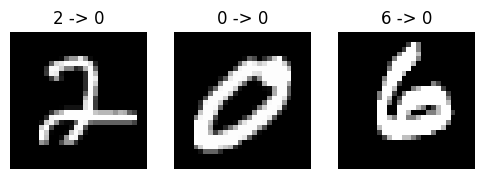

Train Loss: 0.3991, Train Accuracy: 0.8805
Epoch 2/10


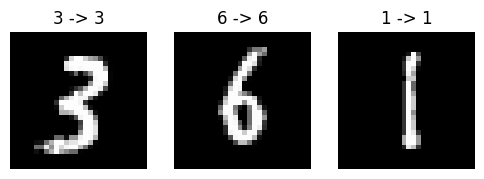

Train Loss: 0.1245, Train Accuracy: 0.9623
Epoch 3/10


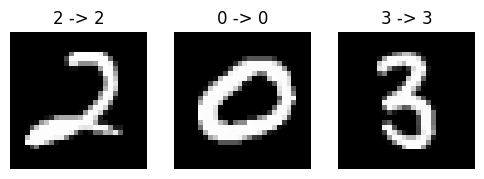

Train Loss: 0.0914, Train Accuracy: 0.9716
Epoch 4/10


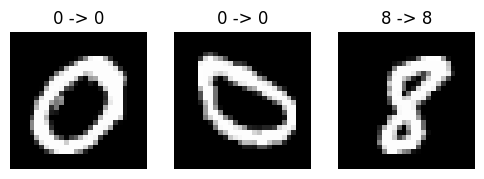

Train Loss: 0.0764, Train Accuracy: 0.9761
Epoch 5/10


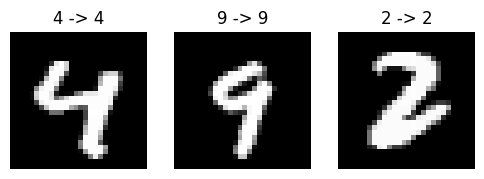

Train Loss: 0.0636, Train Accuracy: 0.9799
Epoch 6/10


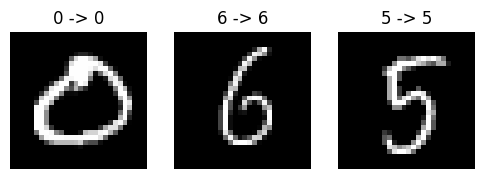

Train Loss: 0.0567, Train Accuracy: 0.9822
Epoch 7/10


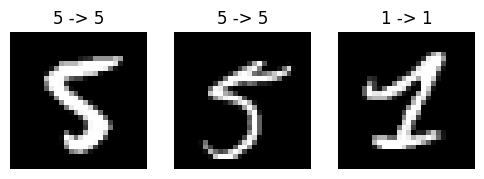

Train Loss: 0.0502, Train Accuracy: 0.9840
Epoch 8/10


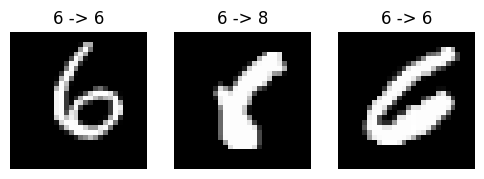

Train Loss: 0.0455, Train Accuracy: 0.9855
Epoch 9/10


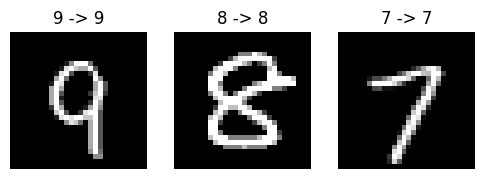

Train Loss: 0.0406, Train Accuracy: 0.9869
Epoch 10/10


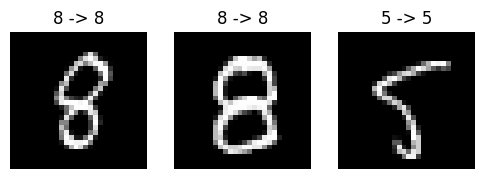

Train Loss: 0.0375, Train Accuracy: 0.9878


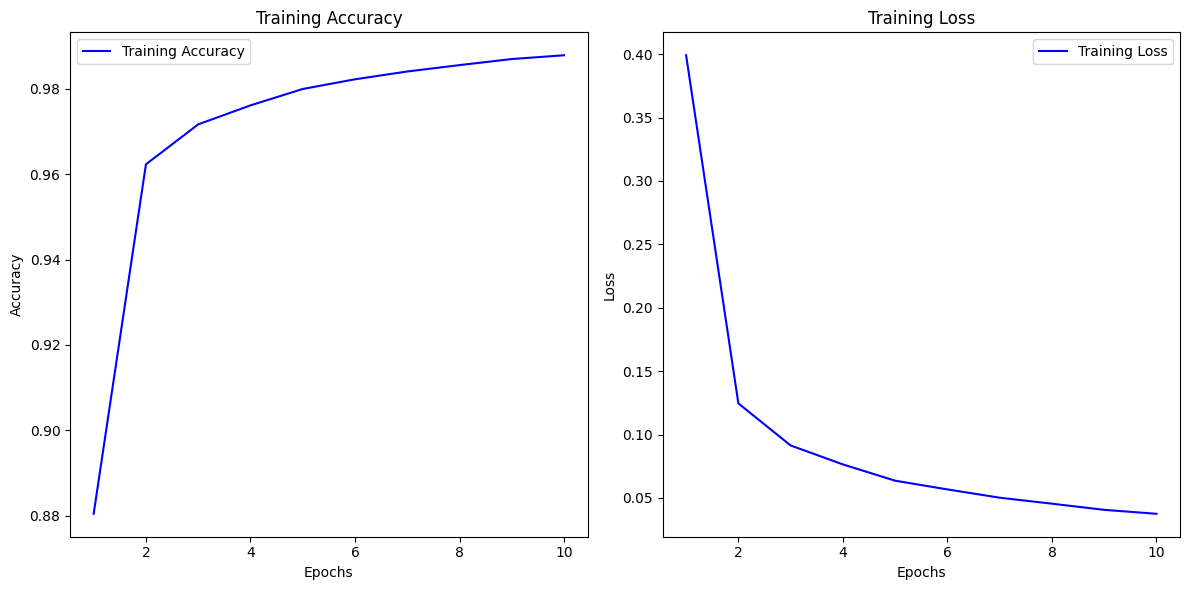

In [39]:
import time
# Start the timer
start_time = time.time()
train_model(hybrid_model, filtered_train_loader, loss_fn, optimizer, num_epochs,device)
# End the timer
end_time = time.time()

In [40]:
# Calculate the training duration in seconds
training_duration_seconds = abs(end_time - start_time)

# Calculate the training duration in minutes
training_duration_minutes = training_duration_seconds / 60

# Calculate the training duration in hours
training_duration_hours = training_duration_minutes / 60

# Print the training duration in different units
print(f"Training duration: {training_duration_seconds:.2f} seconds")
print(f"Training duration: {training_duration_minutes:.2f} minutes")
print(f"Training duration: {training_duration_hours:.2f} hours")

Training duration: 103.62 seconds
Training duration: 1.73 minutes
Training duration: 0.03 hours


In [41]:
def load_clean_model(model, save_dir):
    # Model folder
    model_path = f"{save_dir}/clean_model.pth"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found in {model_path}")

    model.load_state_dict(torch.load(model_path))
    model.eval()

    print(f"Loaded clean_model state dict from {model_path}")
    return model

In [42]:
num_clean_elements = len(filtered_train_set)
print(f"Number of clean images: {num_clean_elements}")

Number of clean images: 54210


In [43]:
import matplotlib.pyplot as plt

def plot_test_accuracy_loss(test_accuracy, test_loss):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(1, test_accuracy, color='r', label='Testing Accuracy')
    plt.title('Testing Accuracy')
    plt.xlabel('Evaluation')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(1, test_loss, color='r', label='Testing Loss')
    plt.title('Testing Loss')
    plt.xlabel('Evaluation')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [44]:
def evaluate(model, data_loader, loss_fn, device):
    test_loss = 0.0
    test_accuracy = 0.0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            test_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)
            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    print(f"Clean Test loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")

    # Plot the test accuracy and loss
    #plot_test_accuracy_loss(test_accuracy, test_loss)

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return test_loss, test_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [45]:
# Model folder
save_dir = 'clean_models'

# Loading
clean_model = load_clean_model(hybrid_model, save_dir)

Loaded clean_model state dict from clean_models/clean_model.pth


In [46]:
from torch.utils.data import TensorDataset
# Evaluation
test_loss, test_acc, misclassified_images, misclassified_labels, misclassified_preds = evaluate(clean_model, filtered_test_loader, loss_fn, device)

Number of clean test images: 64
Number of misclassified images: 2 out of 64
Clean Test loss: 0.0673, Accuracy: 96.88%


In [47]:
import math
def analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds):

    MAX_IMAGES = 60

    if len(misclassified_images) > 0:
        misclassified_images = misclassified_images[0]
        misclassified_labels = misclassified_labels[0]
        misclassified_preds = misclassified_preds[0]

        print(f"Number misclassified: {len(misclassified_images)}")

        # Truncate more than MAX_IMAGES
        images = misclassified_images[:MAX_IMAGES]
        labels = misclassified_labels[:MAX_IMAGES]
        preds = misclassified_preds[:MAX_IMAGES]


        num_images = len(images)

        fig = plt.figure(figsize=(6, num_images))

        rows = math.ceil(num_images / 2)
        cols = 2 if num_images > 16 else min(num_images, 2)

        for i, (img, label, pred) in enumerate(zip(images, labels, preds)):

            # Add subplot
            ax = fig.add_subplot(rows, cols, i+1)

            # Add empty dim if needed
            if img.ndim == 2:
                img = img[:,None,:,]

            # Permute to HWC format for imshow
            img = img.permute(1, 2, 0)

            ax.imshow(img)
            ax.set_title(f"{label} -> {pred}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    else:
        print("No misclassified examples")

    return misclassified_images, misclassified_labels, misclassified_preds

Number misclassified: 2


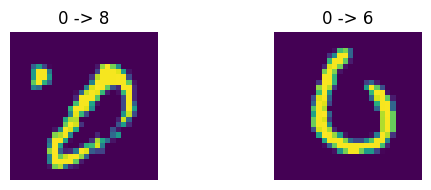

In [48]:
clean_misclassified_images, clean_misclassified_labels, clean_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

In [49]:
model = clean_model
# Define compounded attack
def compounded_attack(choose_attack_option):
    if choose_attack_option == "fgsm_cw_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "fgsm_pgd_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "cw_pgd_attack":
        attack1 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack2 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "pgd_bim_attack":
        attack1 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack2 = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "fgsm_bim_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "cw_bim_attack":
        attack1 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack2 = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "pgd_deepfool_attack":
        attack1 = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=5)
        attack2 = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "fgsm_deepfool_attack":
        attack1 = torchattacks.FGSM(model, eps=0.3)
        attack2 = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "cw_deepfool_attack":
        attack1 = torchattacks.CW(model, c=0.1, kappa=0.0, steps=1000)
        attack2 = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        attack = torchattacks.MultiAttack([attack1, attack2])
    elif choose_attack_option == "bim_deepfool_attack":
        attack1 = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
        attack2 = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        attack = torchattacks.MultiAttack([attack1, attack2])
    else:
        print("You did not chose any of the possible options or an you made an invalid option")
    return attack

In [50]:
attack = compounded_attack(compounded_attack_name)

In [51]:
import tqdm

def perform_adv_attack(model, attack, data_loader):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    total_batches = len(data_loader)
    progress_bar = tqdm.tqdm(total=total_batches, unit='batch', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        # Convert labels to long data type
        y = y.long()

        x_adv = attack(x, y)
        adv_data.append(x_adv.detach())
        adv_labels.append(y.detach())

        progress_bar.update(1)

    progress_bar.close()

    adv_data = torch.cat(adv_data)
    adv_labels = torch.cat(adv_labels)

    # Move data back to CPU if necessary
    if device != torch.device('cpu'):
        adv_data = adv_data.to('cpu')
        adv_labels = adv_labels.to('cpu')

    # Create dataset and loader
    adv_dataset = TensorDataset(adv_data, adv_labels)
    adv_loader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

    return adv_loader

In [52]:
from torch.utils.data import TensorDataset
# Adversarial attack
adv_attack_loader = perform_adv_attack(clean_model, attack, filtered_test_loader)

Adversarial Attack: 100%|██████████| 140/140 [01:02<00:00,  2.25batch/s]


In [53]:
def evaluate_adv_attack(model, data_loader, loss_fn, device):
    attack_test_loss = 0
    attack_test_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            attack_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            attack_test_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)
            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    attack_test_loss /= len(test_loader)
    attack_test_accuracy /= len(test_loader)
    print(f"Attack Test loss: {attack_test_loss:.4f}, Accuracy: {attack_test_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return attack_test_loss, attack_test_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [54]:
# Evaluate attack
clean_attack_test_loss, clean_attack_adv_test_accuracy, misclassified_images, misclassified_labels, misclassified_preds = evaluate_adv_attack(clean_model, adv_attack_loader, loss_fn, device)

print("\nA few key ways to evaluate whether an adversarial attack on a machine learning model was successful:\n")
print("Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.\n")
print("High Loss Value: A sharp spike in loss is another sign of a working attack.\n")
print("Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack\n")


Number of clean test images: 64
Number of misclassified images: 55 out of 64
Attack Test loss: 4.9367, Accuracy: 14.06%

A few key ways to evaluate whether an adversarial attack on a machine learning model was successful:

Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.

High Loss Value: A sharp spike in loss is another sign of a working attack.

Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack



Number misclassified: 55


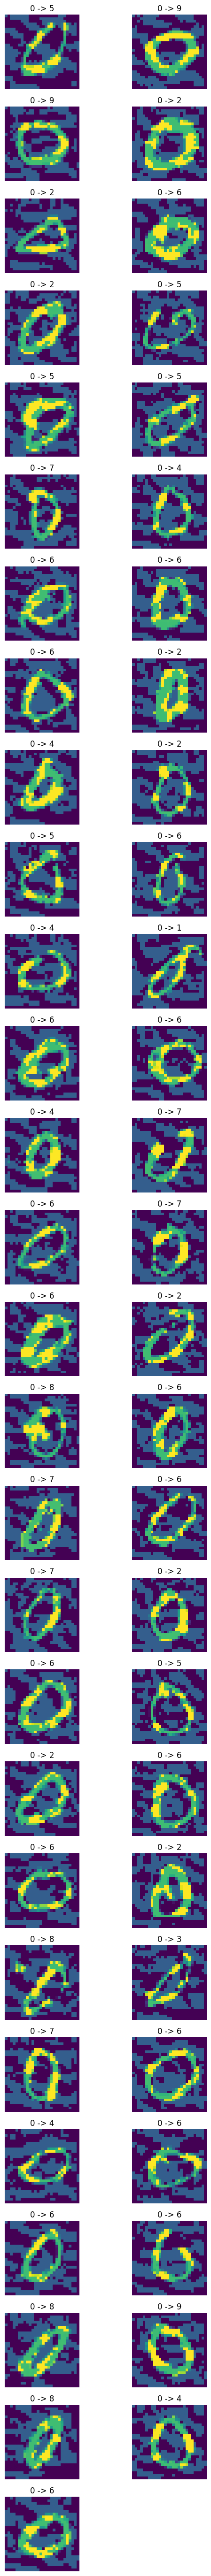

In [55]:
adv_misclassified_images, adv_misclassified_labels, adv_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

In [56]:
# Generate adversarial dataset
import torch
import tqdm
from torch.utils.data import DataLoader, TensorDataset

def generate_adversarial_dataset(model, attack, data_loader, device, num_samples):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    num_generated = 0
    progress_bar = tqdm.tqdm(total=num_samples, unit='sample', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        y = y.long()

        x_adv = attack(x, y)

        with torch.no_grad():
            orig_preds = model(x).argmax(1)
            adv_preds = model(x_adv).argmax(1)

        # Filter samples where original prediction is different from adversarial prediction
        mask = orig_preds != adv_preds
        x_adv_filtered = x_adv[mask]
        y_filtered = y[mask]

        # Append only the required number of samples
        num_remaining = num_samples - num_generated
        if num_remaining > 0:
            if num_remaining >= len(x_adv_filtered):
                adv_data.append(x_adv_filtered.detach())
                adv_labels.append(y_filtered.detach())
                num_generated += len(x_adv_filtered)
                progress_bar.update(len(x_adv_filtered))
            else:
                adv_data.append(x_adv_filtered[:num_remaining].detach())
                adv_labels.append(y_filtered[:num_remaining].detach())
                num_generated = num_samples
                progress_bar.update(num_remaining)
                break

        if num_generated >= num_samples:
            break

    progress_bar.close()

    if len(adv_data) > 0:
        adv_data = torch.cat(adv_data)
        adv_labels = torch.cat(adv_labels)

        if device != torch.device('cpu'):
            adv_data = adv_data.to('cpu')
            adv_labels = adv_labels.to('cpu')

        adv_dataset = TensorDataset(adv_data, adv_labels)

        if num_generated < num_samples:
            print(f"Warning: Could not generate {num_samples} unique adversarial examples.")
            print(f"Returning {num_generated} unique adversarial examples.")
    else:
        adv_dataset = None
        print("Warning: No unique adversarial examples found.")

    return adv_dataset

In [57]:
print(dataset_name)

filtered_test_loader = DataLoader(filtered_test_set, batch_size=64)

# Print the number of batches in the data loaders
print("Number of batches in the filtered test set:", len(filtered_test_loader))

# Calculate the size of the filtered test set
test_set_size = len(filtered_test_loader) * filtered_test_loader.batch_size
if len(filtered_test_set) % filtered_test_loader.batch_size != 0:
    test_set_size += len(filtered_test_set) % filtered_test_loader.batch_size

# Print the sizes of the filtered sets
print("Number of images in the filtered test set:", test_set_size)


MNIST
Number of batches in the filtered test set: 140
Number of images in the filtered test set: 8984


The number of adversarial images used for training as a defense against adversarial attacks on a model follow general guidelines and considerations:

Balanced dataset: It is generally recommended to have a balanced dataset, where the number of adversarial examples is similar to the number of clean examples. This helps the model learn to distinguish between clean and adversarial examples effectively.

Percentage of adversarial examples: A common practice is to include a certain percentage of adversarial examples in the training set. The percentage can range from 10% to 50% of the total training examples, depending on the specific requirements and the sensitivity of the application.

Iterative training: Instead of training with a fixed number of adversarial examples, an iterative approach can be employed. Start with a smaller percentage of adversarial examples and gradually increase the proportion over multiple training iterations. This allows the model to adapt and improve its robustness incrementally.

Diversity of adversarial examples: It is important to generate adversarial examples using different attack methods and parameters to expose the model to a wide range of adversarial perturbations. This helps the model learn to defend against various types of attacks.

Validation and testing: It is crucial to evaluate the model's performance on a separate validation set containing both clean and adversarial examples. This helps assess the model's robustness and generalization ability. The test set should also include a mix of clean and adversarial examples to measure the model's performance in real-world scenarios.

Computational resources: Generating and training with a large number of adversarial examples can be computationally expensive. Consider the available computational resources and time constraints when determining the number of adversarial examples to include in the training process.

In [58]:
global num_of_adv_examples
num_of_adv_examples = int(0.5 * len(filtered_train_set))
print("Number of adversarial examples created:", num_of_adv_examples)

Number of adversarial examples created: 27105


In [59]:
adv_dataset = generate_adversarial_dataset(model, attack, filtered_train_loader, device, num_of_adv_examples)

Adversarial Attack: 100%|██████████| 27105/27105 [04:06<00:00, 109.89sample/s]


In [60]:
# Print adversarial images
def plot_adversarial_images(adv_dataset, model, max_images=60):
    adv_loader = DataLoader(adv_dataset, batch_size=len(adv_dataset))
    images, labels = next(iter(adv_loader))

    # Move the input tensors to the same device as the model
    device = next(model.parameters()).device
    images = images.to(device)

    preds = model(images)

    fig = plt.figure(figsize=(6, 6))
    for i in range(6):
        ax = fig.add_subplot(2, 3, i+1)
        img = images[i].cpu().squeeze()  # Move the image back to CPU for visualization
        ax.imshow(img, cmap='gray')
        orig = labels[i].item()
        pred = preds[i].argmax().item()
        ax.set_title(f"{orig}->{pred}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

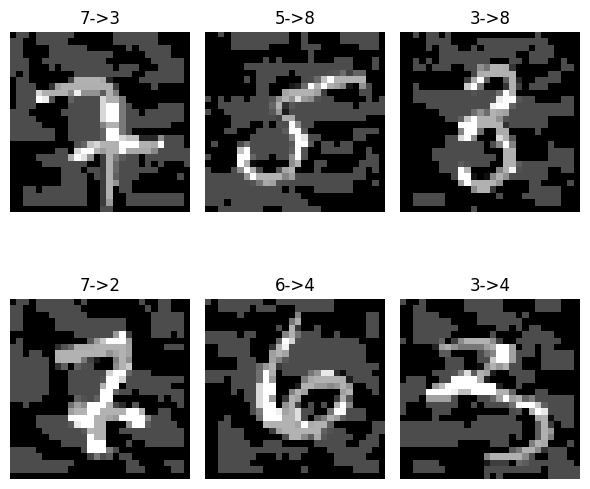

In [61]:
plot_adversarial_images(adv_dataset, model)


In [62]:
from torch.utils.data import DataLoader, TensorDataset

# Adversarial training
# Create adversarial dataset
adv_loader = DataLoader(adv_dataset, batch_size=len(adv_dataset))
adv_images, adv_labels = next(iter(adv_loader))

adv_ds = TensorDataset(adv_images, adv_labels)
adv_batch_size = 128
num_adv_batches = len(adv_ds) // adv_batch_size
num_adv_images = len(adv_ds)

print(f"Number of adversarial images: {num_adv_images}")
print(f"Number of batches (with batch size {adv_batch_size}): {num_adv_batches}")

Number of adversarial images: 27105
Number of batches (with batch size 128): 211


In [63]:
# Filtered training set
filtered_train_set, filtered_test_set = filtered_dataset(train_set, test_set, filtered=1)
clean_loader = DataLoader(filtered_train_set, batch_size=len(filtered_train_set))
clean_images, clean_labels = next(iter(clean_loader))
clean_ds = TensorDataset(clean_images, clean_labels)
clean_batch_size = 128
num_clean_batches = len(clean_ds) // clean_batch_size
num_clean_images = len(clean_ds)

# Clean images
# Print the number of images in the filtered training set
print("Number of clean images in training set:", num_clean_images)
print(f"Number of batches (with batch size {clean_batch_size}): {num_clean_batches}")

Number of clean images in training set: 54210
Number of batches (with batch size 128): 423


In [64]:
# Combine into one dataset
combined_tensors = (torch.cat((adv_images, clean_images)), torch.cat((adv_labels, clean_labels)))
combined_tensor_dataset = TensorDataset(*combined_tensors)

combined_batch_size = 128
num_combined_batches = len(combined_tensor_dataset) // combined_batch_size
num_combined_images = len(combined_tensor_dataset)

# Create combined data loader
combineloader = DataLoader(combined_tensor_dataset, batch_size=128,
                                 shuffle=True, num_workers=4)

In [65]:
# Combined images
print(f"Number of combined images: {num_combined_images}")
print(f"Number of batches in combined loader: {num_combined_batches}")

Number of combined images: 81315
Number of batches in combined loader: 635


Randomization defense techniques involve applying random transformations to the input data during training to increase the model's robustness against adversarial attacks. The key idea behind randomization defense is to introduce random variations in the input data, making it harder for adversarial perturbations to have a consistent effect on the model's predictions.
The implemented randomization defense methods work as follows:

Random Resizing: The input images are randomly resized within a specified scale range. This introduces variations in the spatial dimensions of the images, making the model more resilient to size-related adversarial perturbations.

Random Cropping: A random smaller region is cropped from the input images. This helps the model learn to focus on different parts of the image and reduces its sensitivity to specific pixel locations.
Random Rotation: The input images are randomly rotated within a specified angle range. This helps the model become invariant to rotational changes and enhances its ability to recognize objects from different orientations.

Combined Randomization: Multiple randomization techniques, including resizing, cropping, rotation, color jittering, random erasing, and noise injection, are applied together. This creates a diverse set of input variations, making it challenging for adversarial perturbations to have a consistent impact.

In [66]:
def apply_randomization_defense(dataset, randomization_defense):
    if randomization_defense == "random_resizing":
        transform = transforms.Compose([
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.3)),
            transforms.ToTensor()
        ])
    elif randomization_defense == "random_cropping":
        transform = transforms.Compose([
            transforms.RandomCrop(size=(20, 20)),
            transforms.Resize(size=(28, 28)),
            transforms.ToTensor()
        ])
    elif randomization_defense == "random_rotation":
        transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30, 30)),
            transforms.ToTensor()
        ])
    elif randomization_defense == "combined_randomization":
        transform = transforms.Compose([
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.3)),
            transforms.RandomCrop(size=(20, 20)),
            transforms.Resize(size=(28, 28)),
            transforms.RandomRotation(degrees=(-30, 30)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x))
        ])
    else:
        transform = transforms.ToTensor()

    dataset.transform = transform
    return dataset

In [67]:
def save_retrained_model(model, save_dir):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = f"{save_dir}/retrained_model.pth"

    torch.save(model.state_dict(), model_path)
    #print(f"Saved retrained_model state dict to {model_path}")

Input Transformation
Input transformation is a defense technique that aims to preprocess the input data before feeding it into the model. The goal is to make the input more robust and less susceptible to adversarial perturbations. This project implements three input transformation approaches:

Image Quilting: This technique involves dividing the input image into smaller patches and randomly replacing some of the patches with patches from clean images. The idea is to introduce randomness and break up the adversarial patterns.

Adversarial Logit Pairing: In this approach, adversarial examples are generated using the Fast Gradient Sign Method (FGSM), and the model is trained to minimize the difference between the logits (pre-softmax outputs) of clean examples and their corresponding adversarial examples. This encourages the model to have similar predictions for clean and adversarial inputs.

Differential Privacy: Differential privacy is a technique that adds controlled noise to the input data to protect the privacy of individual examples. In the context of adversarial defense, adding noise can help mitigate the impact of adversarial perturbations by making them less effective.


In [68]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

In [69]:
from skimage.util import view_as_windows
def apply_image_quilting(images, patch_size=8):
    # Convert images to numpy array
    images_np = images.numpy()

    # Reshape images to have three dimensions (batch size, height, width)
    images_np = images_np.reshape(images_np.shape[0], 28, 28)

    # Extract patches from the images
    patches = view_as_windows(images_np, (1, patch_size, patch_size), step=patch_size)
    patches = patches.reshape((-1, 1, patch_size, patch_size))

    # Randomly select and replace patches
    num_patches = patches.shape[0]
    random_indices = np.random.choice(num_patches, size=num_patches, replace=True)
    quilted_patches = patches[random_indices]

    # Reconstruct the quilted images
    num_images = images_np.shape[0]
    quilted_images_np = np.empty_like(images_np)
    for i in range(num_images):
        quilted_images_np[i] = reconstruct_image(quilted_patches[i * num_patches // num_images: (i + 1) * num_patches // num_images], patch_size, images_np.shape[1:])

    # Convert quilted images back to tensor
    quilted_images = torch.from_numpy(quilted_images_np)

    return quilted_images

In [70]:
def reconstruct_image(patches, patch_size, image_size):
    num_patches_per_dim = (image_size[0] + patch_size - 1) // patch_size
    reconstructed_image = np.zeros((1, image_size[0], image_size[1]))

    for i in range(num_patches_per_dim):
        for j in range(num_patches_per_dim):
            patch_index = i * num_patches_per_dim + j
            if patch_index < patches.shape[0]:
                patch = patches[patch_index]
                start_i = i * patch_size
                end_i = min(start_i + patch_size, image_size[0])
                start_j = j * patch_size
                end_j = min(start_j + patch_size, image_size[1])
                reconstructed_image[0, start_i:end_i, start_j:end_j] = patch[0, :end_i-start_i, :end_j-start_j]

    return reconstructed_image

In [71]:
def apply_adversarial_logit_pairing(model, images, epsilon=0.1):
    # Get the device of the model
    device = next(model.parameters()).device

    # Move the images to the same device as the model
    images = images.to(device)

    # Get the labels of the images
    with torch.no_grad():
        labels = model(images).argmax(dim=1)

    # Generate adversarial examples
    images.requires_grad = True
    logits = model(images)
    loss = F.cross_entropy(logits, labels)
    model.zero_grad()
    loss.backward()
    grad = images.grad.data
    adversarial_images = images + epsilon * grad.sign()
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    # Perform adversarial logit pairing
    logits_clean = model(images)
    logits_adv = model(adversarial_images)
    loss_pairing = F.mse_loss(logits_adv, logits_clean)
    model.zero_grad()
    loss_pairing.backward()

    return adversarial_images.detach()

In [72]:
def apply_differential_privacy(images, epsilon=1.0, sensitivity=1.0):
    # Add Gaussian noise to the images
    scale = sensitivity * np.sqrt(2 * np.log(1.25 / 0.01)) / epsilon
    noise = torch.normal(0, scale, images.shape)
    dp_images = images + noise
    dp_images = torch.clamp(dp_images, 0, 1)

    return dp_images

In [73]:
def apply_combined_input_transformation(model, images, labels, patch_size=8, epsilon_alp=0.1, epsilon_dp=1.0):
    quilted_images = apply_image_quilting(images, patch_size)
    paired_images = apply_adversarial_logit_pairing(model, quilted_images, labels, epsilon=epsilon_alp)
    transformed_images = apply_differential_privacy(paired_images, epsilon=epsilon_dp)
    return transformed_images

In [74]:
import multiprocessing

In [75]:
from torch.utils.data import ConcatDataset
def adversarial_retraining(model, combined_loader, optimizer, loss_fn, num_epochs, device, defense_type, randomization_defense,input_transformation,
                           batch_size=128, learning_rate=0.001, weight_decay=0.0001,
                           print_images_per_epoch=1):

  # Move the model to the specified device
  model.to(device)

  # Initialize trainable parameters (if needed, adjust based on your quantum circuit)
  theta = torch.randn(1, requires_grad=True, device=device)
  phi = torch.randn(1, requires_grad=True, device=device)

  # Adjust learning rate and weight decay
  for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate
    param_group['weight_decay'] = weight_decay

  train_losses = []
  train_accuracies = []

  if defense_type == "randomization":
    # Apply the selected randomization defense to the clean dataset
    clean_dataset = clean_loader.dataset
    randomized_dataset = apply_randomization_defense(clean_dataset, randomization_defense)
    combined_dataset = ConcatDataset([clean_dataset, randomized_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    if defense_type == "input_transformation":
        # Apply the selected input transformation technique to the clean dataset
        clean_dataset = clean_loader.dataset

        if input_transformation == "image_quilting":
            transformed_dataset = TransformedDataset(clean_dataset, transforms.Lambda(lambda x: apply_image_quilting(x)))
        elif input_transformation == "adversarial_logit_pairing":
            transformed_dataset = TransformedDataset(clean_dataset, transforms.Lambda(lambda x: apply_adversarial_logit_pairing(model, x)))
        elif input_transformation == "differential_privacy":
            transformed_dataset = TransformedDataset(clean_dataset, transforms.Lambda(lambda x: apply_differential_privacy(x)))
        elif input_transformation == "combined_input_transformation":
            transformed_dataset = TransformedDataset(clean_dataset, transforms.Lambda(lambda x: apply_combined_input_transformation(model, x, labels)))

        combined_dataset = ConcatDataset([clean_dataset, transformed_dataset])

        # Set the start method to 'spawn'
        multiprocessing.set_start_method('spawn', force=True)

        # Create the dataloader with 'spawn' start method
        combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4, multiprocessing_context='spawn')

  if defense_type == "adversarial_training":
    combined_loader = combined_loader

  # Training loop
  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Track modified data
    retrained_imgs = []
    retrained_labels = []

    # Iterate through all batches in the data loader
    for i, (imgs, labels) in enumerate(combined_loader):
      # Forward pass through hybrid model
      hybrid_output = model(imgs)

      # Calculate loss, backpropagate, and update parameters
      loss = loss_fn(hybrid_output, labels.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(hybrid_output.data, 1)
      train_total += labels.size(0)
      train_correct += (predicted == labels.to(device)).sum().item()

      # Print images for the first "print_images_per_epoch" iterations
      if i < print_images_per_epoch:
        print_images(imgs.cpu(), labels.cpu(), hybrid_output.cpu(), n=3)

      # Here, you might modify "imgs" or "labels" based on your training logic
      # to represent the "retrained" version (example: add noise)
      retrained_imgs.append(imgs + 0.1 * torch.randn(imgs.size()))  # Example: Add noise
      retrained_labels.append(labels)

    # Calculate and print epoch statistics
    train_loss /= len(combined_loader)
    train_acc = train_correct / train_total
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

  # Plot accuracy and loss curves (if needed)
  plot_accuracy_loss(train_accuracies, train_losses)

  # Save the retrained model (optional)
  save_retrained_model(model, save_dir)

  # Create a new dataset from collected data
  retrained_dataset = TensorDataset(torch.cat(retrained_imgs), torch.cat(retrained_labels))

  return retrained_dataset

Epoch 1/10


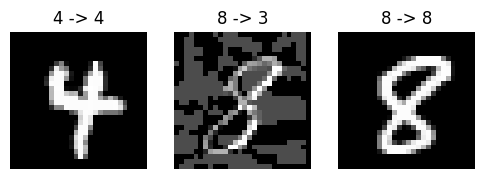

Train Loss: 0.4247, Train Accuracy: 0.8619
Epoch 2/10


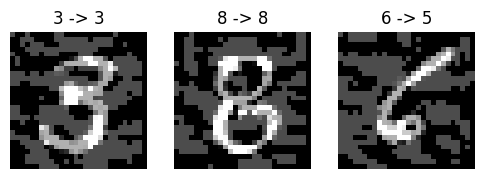

Train Loss: 0.1994, Train Accuracy: 0.9376
Epoch 3/10


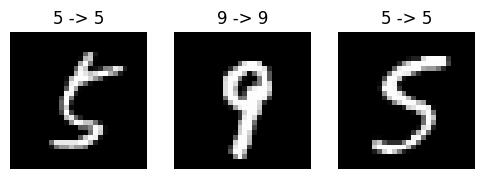

Train Loss: 0.1458, Train Accuracy: 0.9542
Epoch 4/10


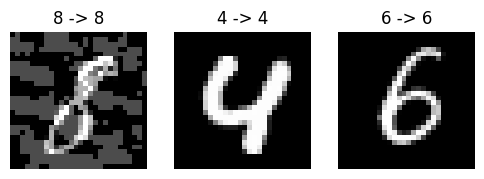

Train Loss: 0.1177, Train Accuracy: 0.9628
Epoch 5/10


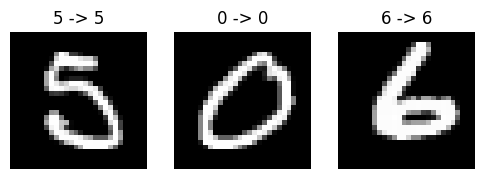

Train Loss: 0.0979, Train Accuracy: 0.9697
Epoch 6/10


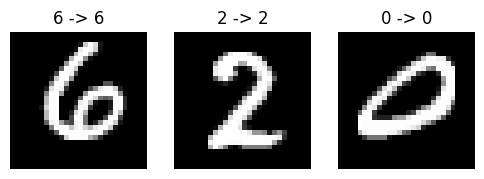

Train Loss: 0.0832, Train Accuracy: 0.9737
Epoch 7/10


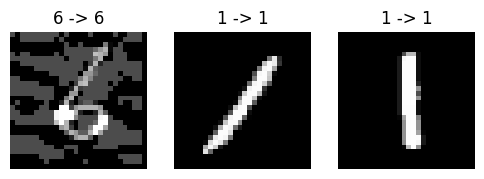

Train Loss: 0.0727, Train Accuracy: 0.9770
Epoch 8/10


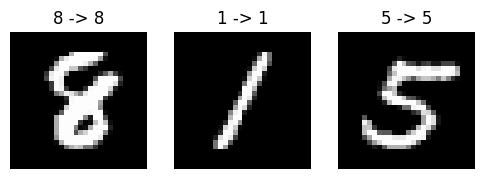

Train Loss: 0.0654, Train Accuracy: 0.9793
Epoch 9/10


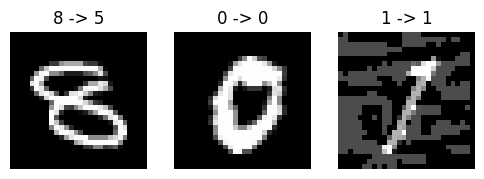

Train Loss: 0.0583, Train Accuracy: 0.9815
Epoch 10/10


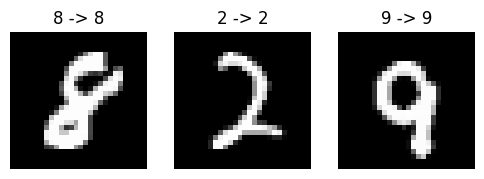

Train Loss: 0.0527, Train Accuracy: 0.9835


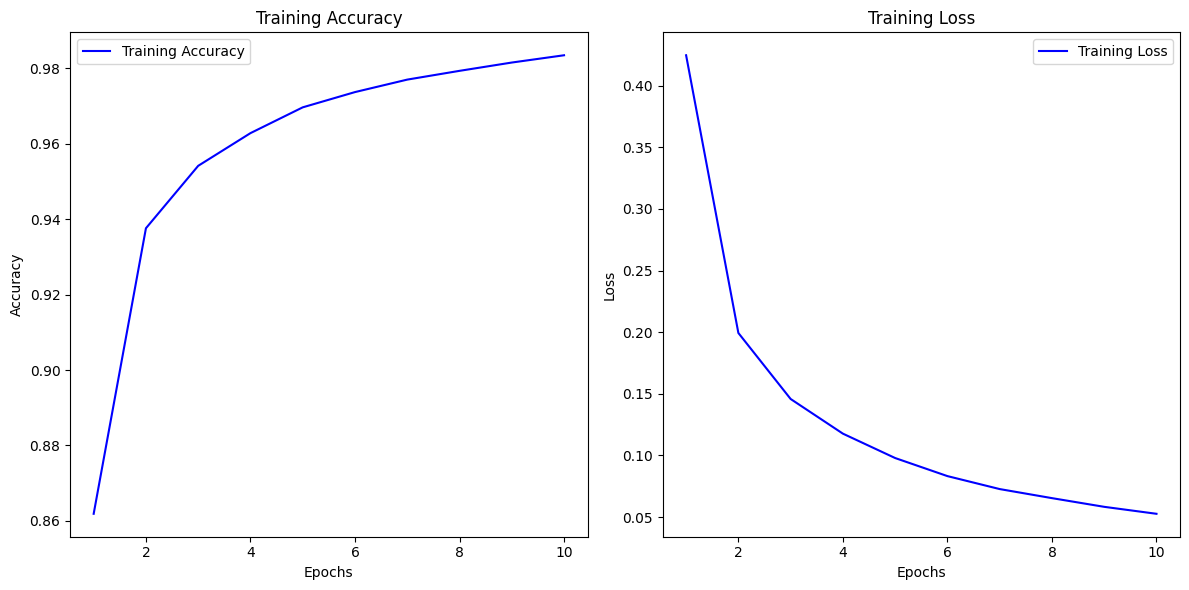

In [76]:
# Start the timer
start_time_retrain = time.time()
adv_trained_dataset = adversarial_retraining(clean_model, combineloader, optimizer, loss_fn, num_epochs, device, defense_type,randomization_defense,input_transformation)
# End the timer
end_time_retrain = time.time()

In [77]:
# Print the training duration in different units

# Calculate the training duration
retraining_duration_seconds = abs(end_time_retrain - start_time_retrain)

# Calculate the training duration in minutes
retraining_duration_minutes = retraining_duration_seconds / 60

# Calculate the training duration in hours
retraining_duration_hours = retraining_duration_minutes / 60

print(f"Training duration: {retraining_duration_seconds:.2f} seconds")
print(f"Training duration: {retraining_duration_minutes:.2f} minutes")
print(f"Training duration: {retraining_duration_hours:.2f} hours")

Training duration: 70.31 seconds
Training duration: 1.17 minutes
Training duration: 0.02 hours


In [78]:
num_clean_elements = 0
num_adv_elements = 0

for clean_images, clean_targets in clean_loader:
    num_clean_elements = len(clean_images)
    print(f"Number of clean images: {num_clean_elements}")

for adv_images, adv_targets in adv_loader:
    num_adv_elements = len(adv_images)
    print(f"Number of adversarial images: {num_adv_elements}")

num_combined_elements = num_clean_elements + num_adv_elements
print(f"Number of combined images: {num_combined_elements}")

adv_trained_images_tensor, adv_trained_labels_tensor = adv_trained_dataset.tensors
num_adv_trained_elements = len(adv_trained_images_tensor)
print(f"Number of adversarially trained images: {num_adv_trained_elements}")

Number of clean images: 54210
Number of adversarial images: 27105
Number of combined images: 81315
Number of adversarially trained images: 81315


In [79]:
def load_retrained_model(model, save_dir):
    # Model folder
    model_path = f"{save_dir}/retrained_model.pth"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found in {model_path}")

    model.load_state_dict(torch.load(model_path))
    model.eval()

    print(f"Loaded retrained_model state dict from {model_path}")
    return model

In [80]:
def evaluate_after_adv_retraining(model, data_loader, loss_fn, device):
    after_adv_test_loss = 0
    after_adv_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    # Create dataset
    dataset_size = len(data_loader.dataset)
    print(f"Number of adv. retrained test images: {dataset_size}")

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)  # Move input data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            after_adv_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            after_adv_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)

            # Filter indices to current batch size
            incorrect_inds = incorrect_inds[incorrect_inds < len(x)]

            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")

    after_adv_test_loss /= len(data_loader)
    after_adv_accuracy /= len(data_loader)
    print(f"Adversarial Retrained Test loss: {after_adv_test_loss:.4f}, Accuracy: {after_adv_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return after_adv_test_loss, after_adv_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [81]:
# Model folder
save_dir = 'clean_models'

# Loading
defense_model = load_retrained_model(model, save_dir)

Loaded retrained_model state dict from clean_models/retrained_model.pth


In [82]:
# Create dataset and loader
adv_retrain_loader = DataLoader(adv_trained_dataset, batch_size=124, shuffle=False)
adv_retrain_test_loss, adv_retrain_test_acc, adv_retrain_misclassified_images, adv_retrain_misclassified_labels, adv_retrain_misclassified_preds = evaluate_after_adv_retraining(defense_model, filtered_test_loader, loss_fn, device)

Number of adv. retrained test images: 8920
Number of misclassified images: 128 out of 8920
Adversarial Retrained Test loss: 0.0433, Accuracy: 98.57%


Number misclassified: 128


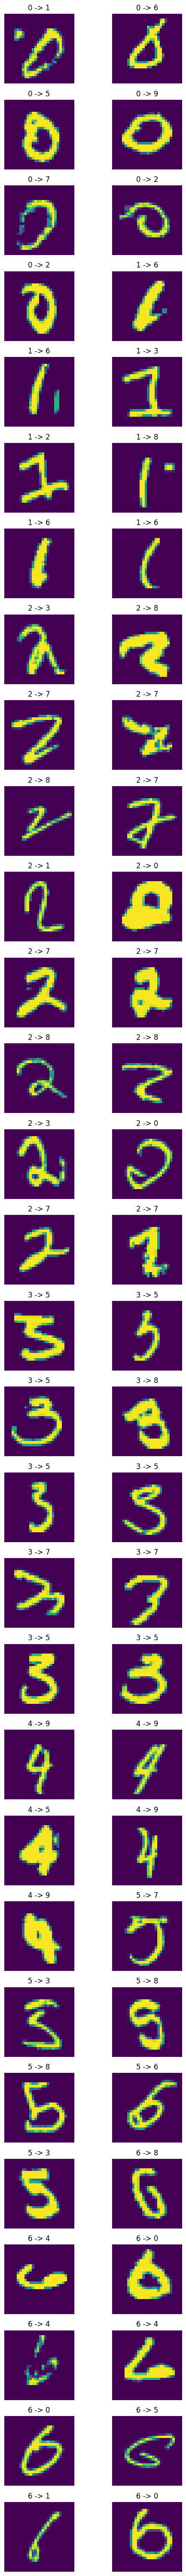

In [83]:
retrained_misclassified_images, retrained_misclassified_labels, retrained_misclassified_preds = analyze_for_misclassifications(adv_retrain_misclassified_images, adv_retrain_misclassified_labels, adv_retrain_misclassified_preds)

In [84]:
import torch
import tqdm
from torch.utils.data import DataLoader, TensorDataset

def perform_adv_attack_after_retraining(model, attack, data_loader, device):
    adv_data = []
    adv_labels = []
    device = next(model.parameters()).device

    total_batches = len(data_loader)
    progress_bar = tqdm.tqdm(total=total_batches, unit='batch', desc='Adversarial Attack')

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        # Convert labels to long data type
        y = y.long()

        x_adv = attack(x, y)
        adv_data.append(x_adv.detach())
        adv_labels.append(y.detach())

        progress_bar.update(1)

    progress_bar.close()

    adv_data = torch.cat(adv_data)
    adv_labels = torch.cat(adv_labels)

    # Move data back to CPU if necessary
    if device != torch.device('cpu'):
        adv_data = adv_data.to('cpu')
        adv_labels = adv_labels.to('cpu')

    # Create dataset and loader
    adv_dataset = TensorDataset(adv_data, adv_labels)
    adv_loader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

    return adv_dataset

In [85]:
print(dataset_name)

filtered_test_loader = DataLoader(filtered_test_set, batch_size=64)

# Print the number of batches in the data loaders
print("Number of batches in the filtered test set:", len(filtered_test_loader))

# Calculate the size of the filtered test set
test_set_size = len(filtered_test_loader) * filtered_test_loader.batch_size
if len(filtered_test_set) % filtered_test_loader.batch_size != 0:
    test_set_size += len(filtered_test_set) % filtered_test_loader.batch_size

# Print the sizes of the filtered sets
print("Number of images in the filtered test set:", test_set_size)

MNIST
Number of batches in the filtered test set: 140
Number of images in the filtered test set: 8984


In [86]:
# Adversarial attack on retrained model
adv_retrain_loader = perform_adv_attack(model, attack, filtered_test_loader)

Adversarial Attack: 100%|██████████| 140/140 [01:06<00:00,  2.11batch/s]


In [87]:
def evaluate_adv_attack_after_retraining(model, data_loader, loss_fn, device):
    atack_after_retrained_test_loss = 0
    atack_after_retrained_accuracy = 0
    num_misclassified = 0
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)  # Move data to the specified device
    num_clean_test_elements = len(images)
    print(f"Number of clean test images: {num_clean_test_elements}")

    # Create dataset
    test_ds = TensorDataset(images, labels)
    # Create loader
    test_loader = DataLoader(test_ds, batch_size=64)
    dataset_size = len(test_loader.dataset)

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)  # Move data to the specified device
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            atack_after_retrained_test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            atack_after_retrained_accuracy += torch.sum(preds == y).item() / len(y)
            incorrect_inds = torch.where(preds != y)[0]
            num_misclassified += len(incorrect_inds)

            # Filter indices to current batch size
            incorrect_inds = incorrect_inds[incorrect_inds < len(x)]

            if len(incorrect_inds) > 0:
                misclassified_images.append(x[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_labels.append(y[incorrect_inds].cpu())  # Move data back to CPU
                misclassified_preds.append(preds[incorrect_inds].cpu())  # Move data back to CPU

    num_misclassified = min(num_misclassified, dataset_size)
    print(f"Number of misclassified images: {num_misclassified} out of {dataset_size}")
    atack_after_retrained_test_loss /= len(test_loader)
    atack_after_retrained_accuracy /= len(test_loader)
    print(f"Adv. Attack Against Retrained Test loss: {atack_after_retrained_test_loss:.4f}, Accuracy: {atack_after_retrained_accuracy:.2%}")

    # Handle empty lists
    if len(misclassified_images) == 0:
        misclassified_images.append(torch.tensor([]))
    if len(misclassified_labels) == 0:
        misclassified_labels.append(torch.tensor([]))
    if len(misclassified_preds) == 0:
        misclassified_preds.append(torch.tensor([]))

    return atack_after_retrained_test_loss, atack_after_retrained_accuracy, [torch.cat(misclassified_images)], [torch.cat(misclassified_labels)], [torch.cat(misclassified_preds)]

In [88]:
# Evaluate attack after retraining
retrained_test_loss, retrained_accuracy, misclassified_images, misclassified_labels, misclassified_preds = evaluate_adv_attack_after_retraining(defense_model, filtered_test_loader, loss_fn, device)
print("\nA few key ways to evaluate whether an adversarial attack on a machine learning model was successful:\n")
print("Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.\n")
print("High Loss Value: A sharp spike in loss is another sign of a working attack.\n")
print("Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack\n")

Number of clean test images: 64
Number of misclassified images: 0 out of 64
Adv. Attack Against Retrained Test loss: 0.0101, Accuracy: 100.00%

A few key ways to evaluate whether an adversarial attack on a machine learning model was successful:

Drop in Model Accuracy: 20-40% drop in accuracy indicates the attack was effective.

High Loss Value: A sharp spike in loss is another sign of a working attack.

Misclassified Examplese: Images wrongly labeled indicates a successful targeted attack



In [89]:
retrained_misclassified_images, retrained_misclassified_labels, retrained_misclassified_preds = analyze_for_misclassifications(misclassified_images, misclassified_labels, misclassified_preds)

Number misclassified: 0


<Figure size 600x0 with 0 Axes>

In [90]:
def precision(true_positives, false_positives):
    if true_positives + false_positives == 0:
        return 0.0
    return true_positives / (true_positives + false_positives)

In [91]:
def recall(true_positives, false_negatives):
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)

In [92]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [93]:
from sklearn.metrics import roc_auc_score

def auc_score(true_labels, predicted_probabilities):
    if len(set(true_labels)) == 2:
        return roc_auc_score(true_labels, predicted_probabilities)
    else:
        return "ROC AUC score is not defined for a single class."

In [94]:
def print_summary_images(images, labels, preds, stage, attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epoch, num_test_images):
    # Check for no images
    if len(images) == 0:
        print(f"\n---------------------------------------------------------")
        print(f"No misclassified images for stage: {stage}")
        print(f"Attack: {attack_name}")
        print(f"Dataset: {dataset_name}")
        print(f"Training Epochs: {num_epoch}")
        if stage == "Clean":
            print(f"Trained Clean Images: {num_clean_elements}")
            accuracy = test_acc
        elif stage == "No Defense Attack":
            print(f"Adversarial Training Images: {num_adv_elements}")
            accuracy = clean_attack_adv_test_accuracy
        elif stage == "w/ Defense Attack":
            print(f"Retrained Clean and Adversarial Images: {num_combined_elements}")
            accuracy = retrained_accuracy
        print(f"Test Images: {num_test_images}")
        print(f"Accuracy: {accuracy:.2f}")

        true_positives = int(accuracy * num_test_images)
        false_positives = 0
        false_negatives = num_test_images - true_positives

        precision_value = precision(true_positives, false_positives)
        recall_value = recall(true_positives, false_negatives)
        f1_score_value = f1_score(precision_value, recall_value)

        # Create the true labels and predicted probabilities based on the variables
        true_labels = [1] * true_positives + [0] * false_negatives
        predicted_probabilities = [1] * true_positives + [0] * false_negatives
        auc = auc_score(true_labels, predicted_probabilities)

        print(f"Precision: {precision_value:.2f}")
        print(f"Recall: {recall_value:.2f}")
        print(f"F1-score: {f1_score_value:.2f}")
        if isinstance(auc, float):
            print(f"ROC AUC Score: {auc:.2f}")
        else:
            print(auc)
        print(f"---------------------------------------------------------\n")
    else:
        # Count the number of misclassifications for each situation
        misclassifications = {}
        for label, pred in zip(labels, preds):
            if label != pred:
                key = f"{label} -> {pred}"
                misclassifications[key] = misclassifications.get(key, 0) + 1

        # Plot images
        num_images = len(images)
        print(f"\n---------------------------------------------------------")
        print(f"Number of misclassified images for {stage}: {num_images}")
        print(f"Attack: {attack_name}")
        print(f"Dataset: {dataset_name}")
        print(f"Training Epochs: {num_epoch}")
        if stage == "Clean":
            print(f"Trained Clean Images: {num_clean_elements}")
            accuracy = test_acc
        elif stage == "No Defense Attack":
            print(f"Adversarial Training Images: {num_adv_elements}")
            accuracy = clean_attack_adv_test_accuracy
        elif stage == "w/ Defense Attack":
            print(f"Retrained Clean and Adversarial Images: {num_combined_elements}")
            accuracy = retrained_accuracy
        print(f"Test Images: {num_test_images}")
        print(f"Accuracy: {accuracy:.2f}")

        true_positives = int(accuracy * num_test_images)
        false_positives = num_images
        false_negatives = num_test_images - true_positives - false_positives

        precision_value = precision(true_positives, false_positives)
        recall_value = recall(true_positives, false_negatives)
        f1_score_value = f1_score(precision_value, recall_value)

        # Create the true labels and predicted probabilities based on the variables
        true_labels = [1] * true_positives + [0] * false_negatives
        predicted_probabilities = [1] * true_positives + [0] * false_negatives
        auc = auc_score(true_labels, predicted_probabilities)

        print(f"Precision: {precision_value:.2f}")
        print(f"Recall: {recall_value:.2f}")
        print(f"F1-score: {f1_score_value:.2f}")
        if isinstance(auc, float):
            print(f"ROC AUC Score: {auc:.2f}")
        else:
            print(auc)
        print(f"---------------------------------------------------------\n")

        fig = plt.figure(figsize=(6, num_images))
        rows = math.ceil(num_images / 2)
        cols = 2 if num_images > 16 else min(num_images, 2)
        for i, (img, label, pred) in enumerate(zip(images, labels, preds)):
            # Add subplot
            ax = fig.add_subplot(rows, cols, i+1)
            # Add empty dim if needed
            if img.ndim == 2:
                img = img[:,None,:,]
            # Permute to HWC format for imshow
            img = img.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(f"{label} -> {pred}")
            ax.axis("off")

        # Print the number of misclassifications for each situation
        print("Misclassifications:")
        for situation, count in misclassifications.items():
            print(f"{situation}: {count}")

        plt.tight_layout()
        plt.show()

In [95]:
print("Number of clean images in training set:", num_clean_images)
print(f"Number of clean batches: {num_clean_batches}")

print(f"Number of adversarial images: {num_adv_images}")
print(f"Number of adversarial batches: {num_adv_batches}")

print(f"Number of combined images: {num_combined_images}")
print(f"Number of combined batches: {num_combined_batches}")

Number of clean images in training set: 54210
Number of clean batches: 423
Number of adversarial images: 27105
Number of adversarial batches: 211
Number of combined images: 81315
Number of combined batches: 635


In [96]:
import tabulate

In [97]:
def summarize_performance(clean_loss, clean_acc, adv_loss, adv_acc, retrain_loss, retrain_acc,
                          clean_misclassified_images, adv_misclassified_images, retrained_misclassified_images,
                          clean_misclassified_labels, adv_misclassified_labels, retrained_misclassified_labels,
                          clean_misclassified_preds,adv_misclassified_preds, retrained_misclassified_preds, defense_type,randomization_defense):

    if (defense_type == "adversarial_training"):
      print("Defense Implemented: Adversarial Training\n")
    elif (defense_type == "randomization"):
      print("Defense Implemented: Randomization\n")
      if (randomization_defense == "random_resizing"):
        print("Randomization Approach: Random Resizing\n")
      elif(randomization_defense == "random_cropping"):
        print("Randomization Approach: Random Cropping\n")
      elif(randomization_defense == "random_rotation"):
        print("Randomization Approach: Random Rotation\n")
      elif(randomization_defense == "combined_randomization"):
        print("Randomization Approach: Combined Randomization\n")
    elif (defense_type == "input_transformation"):
      print("Defense Implemented: Input Transformation\n")
      if (input_transformation == "image_quilting"):
         print("Input Transformation Approach: Image Quilting\n")
      elif (input_transformation == "adversarial_logit_pairing"):
        print("Input Transformation Approach: Adversarial Logit Pairing\n")
      elif (input_transformation == "differential_privacy"):
        print("Input Transformation Approach: Differential Privacy\n")
      elif (input_transformation == "combined_input_transformation"):
        print("Input Transformation Approach: Combined Input Transformation\n")

    table_data = [["Metric", "Clean", "No Defense Attack", "w/ Defense Attack"],
                  ["Loss", f'{clean_loss:.3g}', f'{adv_loss:.3g}', f'{retrain_loss:.3g}'],
                  ["Accuracy", f'{clean_acc:.0%}', f'{adv_acc:.0%}', f'{retrain_acc:.0%}']]

    print(tabulate.tabulate(table_data, headers="firstrow", tablefmt="grid"))

    print("\nExample Misclassifications:")
    print_summary_images(clean_misclassified_images, clean_misclassified_labels, clean_misclassified_preds, "Clean", compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))
    print_summary_images(adv_misclassified_images, adv_misclassified_labels, adv_misclassified_preds, "No Defense Attack",  compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))
    print_summary_images(retrained_misclassified_images, retrained_misclassified_labels, retrained_misclassified_preds, "w/ Defense Attack",  compounded_attack_name, dataset_name, num_clean_elements, num_adv_elements, num_combined_elements, num_epochs, len(filtered_test_loader))

Defense Implemented: Input Transformation

Input Transformation Approach: Combined Input Transformation

+----------+---------+---------------------+---------------------+
| Metric   | Clean   | No Defense Attack   | w/ Defense Attack   |
+==========+=========+=====================+=====================+
| Loss     | 0.0673  | 4.94                | 0.0101              |
+----------+---------+---------------------+---------------------+
| Accuracy | 97%     | 14%                 | 100%                |
+----------+---------+---------------------+---------------------+

Example Misclassifications:

---------------------------------------------------------
Number of misclassified images for Clean: 2
Attack: fgsm_cw_attack
Dataset: MNIST
Training Epochs: 10
Trained Clean Images: 54210
Test Images: 140
Accuracy: 0.97
Precision: 0.99
Recall: 0.98
F1-score: 0.98
ROC AUC Score: 1.00
---------------------------------------------------------

Misclassifications:
0 -> 8: 1
0 -> 6: 1


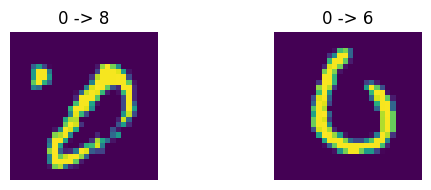


---------------------------------------------------------
Number of misclassified images for No Defense Attack: 55
Attack: fgsm_cw_attack
Dataset: MNIST
Training Epochs: 10
Adversarial Training Images: 27105
Test Images: 140
Accuracy: 0.14
Precision: 0.26
Recall: 0.22
F1-score: 0.24
ROC AUC Score: 1.00
---------------------------------------------------------

Misclassifications:
0 -> 5: 6
0 -> 9: 3
0 -> 2: 9
0 -> 6: 19
0 -> 7: 6
0 -> 4: 6
0 -> 1: 1
0 -> 8: 4
0 -> 3: 1


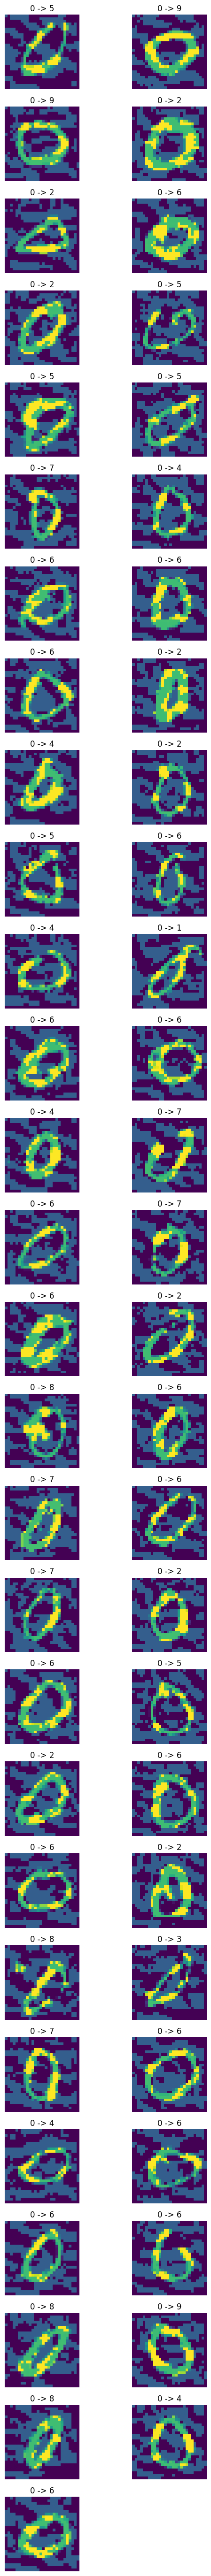


---------------------------------------------------------
No misclassified images for stage: w/ Defense Attack
Attack: fgsm_cw_attack
Dataset: MNIST
Training Epochs: 10
Retrained Clean and Adversarial Images: 81315
Test Images: 140
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
ROC AUC score is not defined for a single class.
---------------------------------------------------------



In [98]:
summarize_performance(test_loss, test_acc, clean_attack_test_loss, clean_attack_adv_test_accuracy, retrained_test_loss, retrained_accuracy,
                          clean_misclassified_images, adv_misclassified_images, retrained_misclassified_images,
                          clean_misclassified_labels, adv_misclassified_labels, retrained_misclassified_labels,
                          clean_misclassified_preds,adv_misclassified_preds, retrained_misclassified_preds, defense_type,randomization_defense)